In [9]:
import cv2 
import numpy as np 
import time
import matplotlib.pyplot as plt
import torch 
import importlib
import math
from pycocotools.coco import COCO
import skimage.io as io
import pylab
from sklearn.linear_model import LinearRegression


dpt = importlib.import_module("Depth-Anything-V2.depth_anything_v2.dpt")
DepthAnythingV2 = dpt.DepthAnythingV2

util_transform = importlib.import_module("Depth-Anything-V2.depth_anything_v2.util.transform")

torch.cuda.is_available()

ModuleNotFoundError: No module named 'Depth-Anything-V2'

Função com parametros da camera:

In [ ]:
# Parametros
real_height = 400   # mm
image_height = 1080 # pixels
sensor_height = 5.4 # mm  
focal_length = 18   # mm

def calculate_distance(radius):
    # https://photo.stackexchange.com/questions/12434/how-do-i-calculate-the-distance-of-an-object-in-a-photo
    dem = focal_length * real_height * image_height 
    num = sensor_height * 2*radius 
    
    distance_meters = dem/num/1000 
    return distance_meters

In [ ]:
def blur_image(img, kernel=3,ERO=False,DIL=False,kernel2=3):
    # blur image, and maybe Erode and Dilate based on flags.

    # Convert to grayscale. 
    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 

    # Blur using kernel. 
    gray_blurred = cv2.blur(img, (kernel, kernel)) 

    # gray_blurred = cv2.medianBlur(gray, 3) 
    
    
    if ERO:
        ero = cv2.erode(gray_blurred, np.ones((kernel2 ,kernel2)))
        gray_blurred = ero
    if DIL:
        dil = cv2.dilate(gray_blurred, np.ones((kernel2,kernel2)))
        gray_blurred = dil

    return gray_blurred

def check_depth_in_a_circle(depth, pt):
    x,y = pt[0],pt[1]
    r = pt[2]

    ix_min, ix_max = (np.max([np.floor(x-r),0]).astype(int), np.min([np.ceil(x+r),1918-1]).astype(int))
    iy_min, iy_max = (np.max([np.floor(y-r),0]).astype(int), np.min([np.ceil(y+r),1078-1]).astype(int))

    max = 0
    for ix in range(ix_min, ix_max):
        for iy in range(iy_min, iy_max):
            if( (ix-x)**2 + (iy-y)**2 <= r**2):

                if depth[iy,ix] > max:
                    max = depth[iy,ix]

    return max



In [ ]:
def find_seg_img(filename,seg_file_names):
    for i, seg_name in enumerate(seg_file_names[:-1]):
        if filename > seg_name and filename < seg_file_names[i+1]:
            return seg_name
    return seg_file_names[-1]

seg_file_names = [coco.imgs[id]['file_name'].split('/')[-1].split('-',1)[1] for id in coco.getImgIds()]

# # print(seg_file_names)
# find_seg_img('14-10-2024_09-40-25_track_15_cam_0',seg_file_names)

'foto.jpg'

In [ ]:


# initialize COCO api for instance annotations
coco=COCO(annFile)

imgFile='{}/images/{}'.format(dataDir,coco.imgs[image_id]['file_name'].split('/')[-1])
raw_image = cv2.imread(imgFile)

# Crop image to size be multiple of 14
raw_image_h,raw_image_w,_ = raw_image.shape
np.floor(raw_image_h/14)*14
np.floor(raw_image_w/14)*14
raw_image = raw_image[:int(np.floor(raw_image_h/14)*14),:int(np.floor(raw_image_w/14)*14),:]

# cv2.polylines(image_segmentatted, [seg_xy], 1, (255,255,255), 1)



loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [ ]:
# processed_img = blur_image(img_segmation,1,True,True,kernel2=2)
processed_img = img_segmation
image_with_detection = raw_image.copy()

print("shape:", processed_img.shape)
detected_circles = cv2.HoughCircles(processed_img,  
                   cv2.HOUGH_GRADIENT, 2, 20*up_sampling, 
                   param1 = 50,     param2 = 10, # param1 = 50, param2= 10
                   minRadius = 1*up_sampling,   maxRadius =10*up_sampling) 

print("numero de circulos detectado:",detected_circles[0, :].__len__())

vector_compare_radius_depth = []

# print(len(detected_circles))
# Draw circles that are detected. 
if detected_circles is not None: 

    for pt in detected_circles[0, :]: 
        a, b, r = pt[0]/up_sampling, pt[1]/up_sampling, pt[2]/up_sampling 
        a, b, r = np.uint32((a,b,r))

        depth_of_circle  = check_depth_in_a_circle(depth, (pt[0]/up_sampling, pt[1]/up_sampling, pt[2]/up_sampling))

        # Write distances
        text = str( round(calculate_distance(pt[2]/up_sampling) ) ) + '; ' +str(round(depth_of_circle))
        
        # Draw the circumference of the circle. 
        cv2.circle(image_with_detection,(a, b),r,(255, 0, 0), 1) 
        cv2.putText(image_with_detection,text,(a,b),fontFace=1,fontScale=1,color=255)
        
        # cv2.circle(processed_img,(a, b),r,(255, 0, 0), 1) 
        # cv2.putText(processed_img,text,(a,b),fontFace=1,fontScale=1,color=255)

        vector_compare_radius_depth.append([a, b, calculate_distance(pt[2]/up_sampling), depth_of_circle])

# image_with_detection

# imS = cv2.resize(processed_img, (960, 540))                # Resize image
# cv2.imshow("output", imS)                       # Show image
# cv2.waitKey(0)                                  # Display the image infinitely until any keypress


# cv2.imshow("Detected Circle", image_with_detection) 
# plt.show()
# cv2.waitKey(0) 
# cv2.destroyAllWindows()


shape: (10780, 19180)
numero de circulos detectado: 13


[0, 1, 2, 3, 4]

In [ ]:
dataDir='./DATASET/balls_segmentation_out'
annFile='{}/result.json'.format(dataDir)
# initialize COCO api for instance annotations
coco=COCO(annFile)

img_shape = [coco.imgs[0]['width'], coco.imgs[0]['height']]
up_sampling = 10 # Up sample to better detect circles

balls_distance = {}
for image_id in coco.getImgIds():
    img_segmation = np.zeros([i*up_sampling for i in img_shape],dtype=np.uint8)
    # image_segmentatted = raw_image.copy()
    
    image_name = coco.imgs[image_id]['file_name'].split('/')[-1].split('-',1)[1]
    balls_distance[image_name] = {}
    print('processing image_id:',image_id,' from ', max(coco.getImgIds()) )
    balls_distance[image_name]['segmentation_coordinates'] = []
    for annotation in coco.imgToAnns[image_id]:
        # annotation = coco.anns[key]
        # if annotation['image_id'] == image_id:
        seg_xy_up = np.array([ [annotation['segmentation'][0][i]*up_sampling, 
                            annotation['segmentation'][0][i+1]*up_sampling ] 
                                for i in range(0,len(annotation['segmentation'][0]),2)] 
                        ,dtype=np.int32)

        cv2.fillPoly(img_segmation, [seg_xy_up], 255)

        seg_xy = np.array([ [annotation['segmentation'][0][i], 
                            annotation['segmentation'][0][i+1] ] 
                                for i in range(0,len(annotation['segmentation'][0]),2)] 
                        ,dtype=np.int32)
        
        balls_distance[image_name]['segmentation_coordinates'].append(seg_xy)
        # cv2.polylines(image_segmentatted, [seg_xy], 1, (255,255,255), 1)
    # processed_img = img_segmation
    detected_circles = cv2.HoughCircles(img_segmation,  
                    cv2.HOUGH_GRADIENT, 2, 20*up_sampling, 
                    param1 = 50,     param2 = 10, # param1 = 50, param2= 10
                    minRadius = 1*up_sampling,   maxRadius =10*up_sampling) 

    print("numero de circulos detectado:",detected_circles[0, :].__len__())
    balls_distance[image_name]['detected_circles'] = detected_circles

loading annotations into memory...


FileNotFoundError: [Errno 2] No such file or directory: './DATASET/balls_segmentation_out/result.json'

In [ ]:
def find_depth(raw_image):
    # https://github.com/DepthAnything/Depth-Anything-V2?tab=readme-ov-file
    torch.cuda.empty_cache()
    print("Memory allocated", torch.cuda.memory_allocated()/1024/1024/1024,"Gb")

    DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
    print("DEVICE:", DEVICE)

    model_configs = {
        'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
        'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
        'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
        'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
    }
        
    encoder = 'vitb' # or 'vits', 'vitl', 'vitg'

    depth_anything = DepthAnythingV2(**model_configs[encoder])
    depth_anything.load_state_dict(torch.load(f'Depth-Anything-V2/depth_anything_v2_{encoder}.pth', map_location='cpu'))
    depth_anything = depth_anything.to(DEVICE).eval()

    # Use model
    depth = depth_anything.infer_image(raw_image, np.floor(raw_image_h/14)*14)

    # Transform in 
    depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
    depth = depth.astype(np.uint8)

In [ ]:
cap = cv2.VideoCapture('10-10-2024_06-56-26_track_246_cam_0.avi_track_242_cam_3.avi')

_, frame = cap.read()
find_depth(frame)

Memory allocated 0.0 Gb
DEVICE: cuda


NameError: name 'DepthAnythingV2' is not defined

In [ ]:
distantece_y = np.array([ i[2] for i in vector_compare_radius_depth])
depth_x = np.array([ [i[3]] for i in vector_compare_radius_depth])


distanceLR = LinearRegression().fit(depth_x,distantece_y)


new_vector_compare_radius_depth = []
# new_depth_x = []
# new_distantece_y = []
new_vector_check = vector_compare_radius_depth
while len(new_vector_check) != len(new_vector_compare_radius_depth) or \
    new_vector_check != new_vector_compare_radius_depth:

    new_vector_compare_radius_depth = []
    for eta in vector_compare_radius_depth:
        loss = (eta[3] * distanceLR.coef_[0] + distanceLR.intercept_ - eta[2])**2
        if loss < 500:
            new_vector_compare_radius_depth.append(eta)

    new_distantece_y = np.array([ i[2] for i in new_vector_compare_radius_depth])
    new_depth_x = np.array([ [i[3]] for i in new_vector_compare_radius_depth])

    distanceLR = LinearRegression().fit(new_depth_x,new_distantece_y)
    new_vector_check = new_vector_compare_radius_depth

distanceLR.coef_ , distanceLR.intercept_ 

(array([-1.05849024]), 326.4481573290108)

In [ ]:
new_vector_check

[[677, 445, 149.37759099655483, 167],
 [1141, 159, 127.65957101430769, 197],
 [827, 980, 260.8695616118174, 58],
 [1085, 786, 220.8589060430658, 91],
 [797, 894, 255.31914202861537, 74],
 [1107, 568, 172.24880697166054, 133],
 [1055, 978, 288.0, 46]]

In [ ]:
image_with_selected_detections = image_with_detection.copy()

for x,y,_,_ in new_vector_compare_radius_depth:
    cv2.circle(image_with_selected_detections, (x,y), 1,(0, 0, 255), 1) 



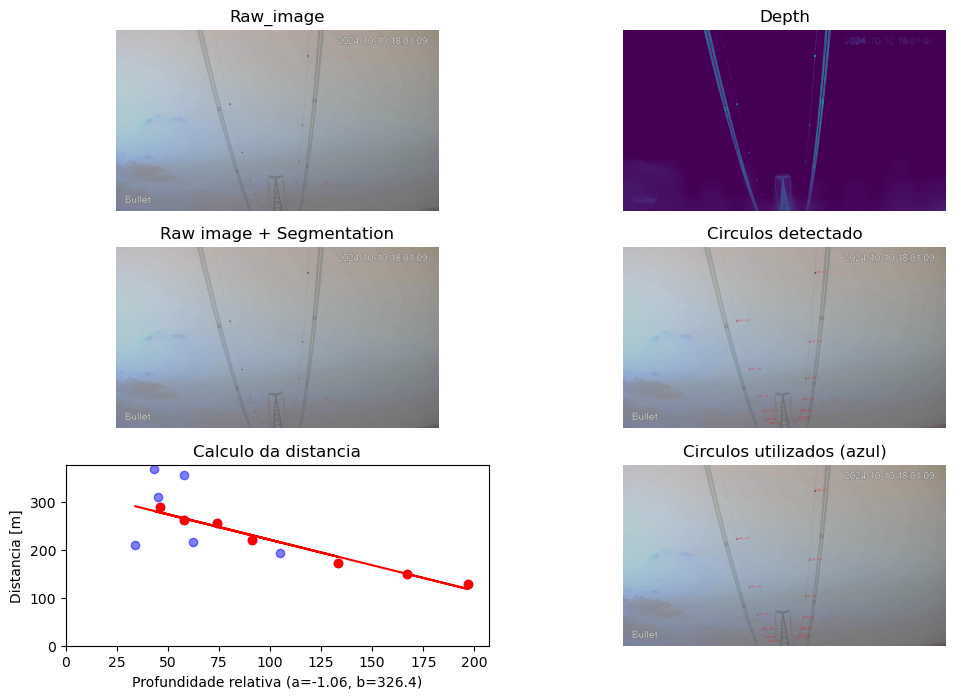

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(3, 2, 1)
plt.imshow(raw_image)
plt.title("Raw_image")
plt.axis("off")

plt.subplot(3, 2, 3)
plt.imshow(image_segmentatted)
plt.title("Raw image + Segmentation")
plt.axis("off")

plt.subplot(3, 2, 2)
plt.imshow(depth)
plt.title("Depth")
plt.axis("off")

plt.subplot(3, 2, 4)
plt.imshow(image_with_detection)
plt.title("Circulos detectado")
plt.axis("off")

plt.subplot(3, 2, 6)
plt.imshow(image_with_selected_detections)
plt.title("Circulos utilizados (azul)")
plt.axis("off")

plt.subplot(3, 2, 5)
plt.scatter(depth_x,distantece_y,c='b',alpha=.5)
plt.scatter(new_depth_x,new_distantece_y,c='r')
plt.plot(depth_x, depth_x * distanceLR.coef_[0] + distanceLR.intercept_, 'r-')
plt.xlabel("Profundidade relativa (a="+str(np.round(distanceLR.coef_[0],2))+", b="+str(np.round(distanceLR.intercept_,1))+")" )
plt.ylabel("Distancia [m]")
plt.title("Calculo da distancia")
plt.xlim((0, np.max(depth_x)+10))
plt.ylim(( 0 , np.max(distantece_y)+10))
# plt.legend(["Todos valores","Valores selecionados","Regressão"])
# plt.tight_layout()
# plt.show()
plt.savefig('./results/output_id='+str(image_id)+'.png',dpi=600)